In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
df = pd.read_csv("cleaned_country_wise_latest.csv")

In [4]:
df.head()
df.info()
df.describe(include="all")
df.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country/region          187 non-null    object 
 1   confirmed               187 non-null    int64  
 2   deaths                  187 non-null    int64  
 3   recovered               187 non-null    int64  
 4   active                  187 non-null    int64  
 5   new_cases               187 non-null    int64  
 6   new_deaths              187 non-null    int64  
 7   new_recovered           187 non-null    int64  
 8   deaths_/_100_cases      187 non-null    float64
 9   recovered_/_100_cases   187 non-null    float64
 10  deaths_/_100_recovered  187 non-null    float64
 11  confirmed_last_week     187 non-null    int64  
 12  1_week_change           187 non-null    int64  
 13  1_week_%_increase       187 non-null    float64
 14  who_region              187 non-null    ob

['country/region',
 'confirmed',
 'deaths',
 'recovered',
 'active',
 'new_cases',
 'new_deaths',
 'new_recovered',
 'deaths_/_100_cases',
 'recovered_/_100_cases',
 'deaths_/_100_recovered',
 'confirmed_last_week',
 '1_week_change',
 '1_week_%_increase',
 'who_region',
 'CFR']

In [5]:
df = df.rename(columns={
    "country/region": "country",
    "deaths_/_100_cases": "deaths_per_100_cases",
    "recovered_/_100_cases": "recovered_per_100_cases",
    "deaths_/_100_recovered": "deaths_per_100_recovered",
    "1_week_change": "week_change",
    "1_week_%_increase": "week_pct_increase",
    "who_region": "who_region"
})

df.columns.tolist()


['country',
 'confirmed',
 'deaths',
 'recovered',
 'active',
 'new_cases',
 'new_deaths',
 'new_recovered',
 'deaths_per_100_cases',
 'recovered_per_100_cases',
 'deaths_per_100_recovered',
 'confirmed_last_week',
 'week_change',
 'week_pct_increase',
 'who_region',
 'CFR']

In [9]:
import altair as alt

subset = df[["country", "week_pct_increase", "CFR", "who_region"]].dropna()

x_med = subset["week_pct_increase"].median()
y_med = subset["CFR"].median()

base = alt.Chart(subset).mark_circle(size=90).encode(
    x=alt.X("week_pct_increase:Q", title="Week % Increase in Cases"),
    y=alt.Y("CFR:Q", title="Case Fatality Rate (CFR)"),
    color=alt.Color("who_region:N", legend=alt.Legend(title="WHO Region")),
    tooltip=["country:N", "week_pct_increase:Q", "CFR:Q"]
).properties(width=600, height=450, title="Growth vs Severity (Hover to See Country)")

vline = alt.Chart(pd.DataFrame({"x": [x_med]})).mark_rule(strokeDash=[6,4]).encode(x="x:Q")
hline = alt.Chart(pd.DataFrame({"y": [y_med]})).mark_rule(strokeDash=[6,4]).encode(y="y:Q")

(base + vline + hline).interactive()


alt.LayerChart(...)

This quadrant plot compares recent growth in cases (week % increase) with severity (case fatality rate). The dashed lines show global medians, dividing countries into four groups. This highlights countries experiencing rapid spread with high fatality versus those with slower growth or lower observed severity.

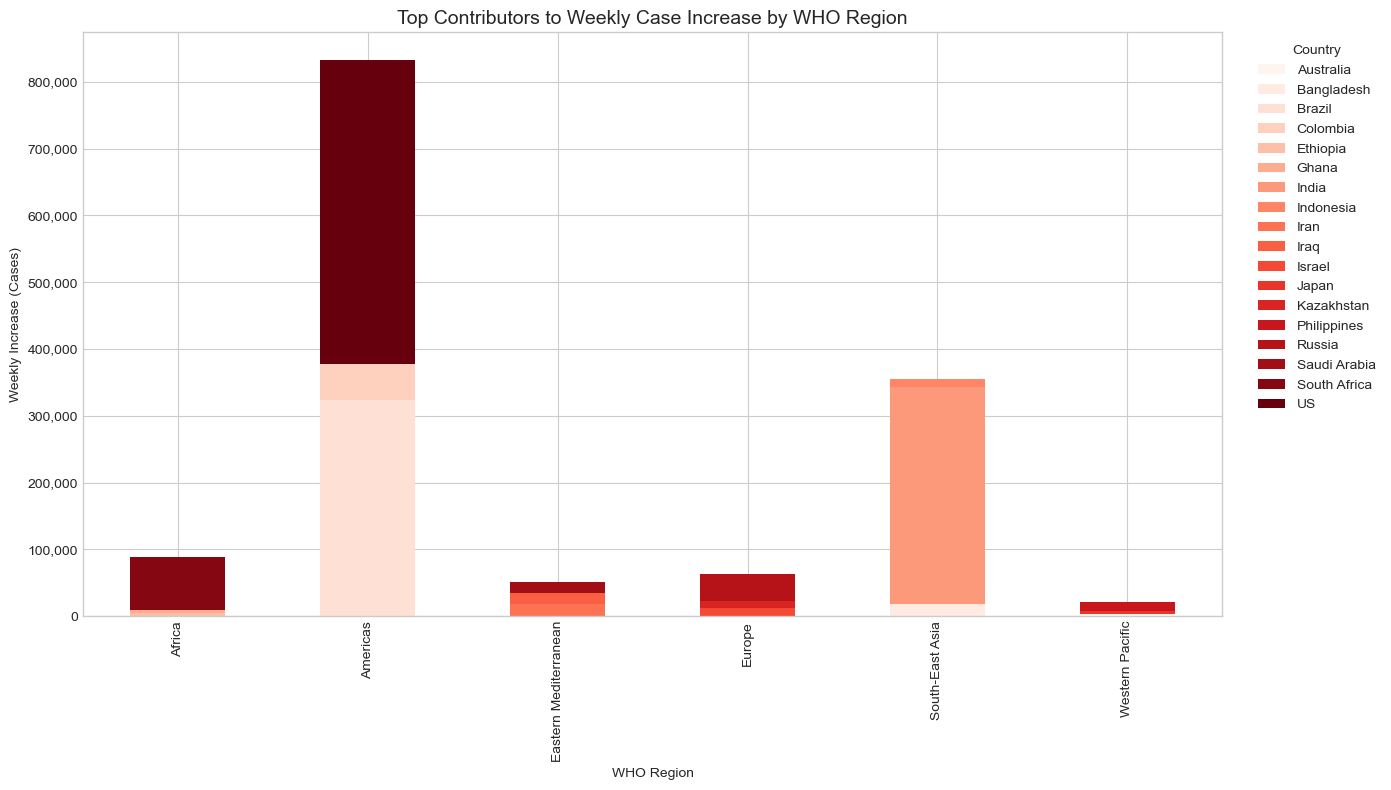

In [13]:
# Prepare positive weekly changes
wk = df.copy()
wk["week_change_pos"] = wk["week_change"].clip(lower=0)

# Top 3 contributors per region (keeps it readable)
top_by_region = (
    wk.sort_values("week_change_pos", ascending=False)
      .groupby("who_region")
      .head(3)
)

pivot = top_by_region.pivot_table(
    index="who_region",
    columns="country",
    values="week_change_pos",
    aggfunc="sum",
    fill_value=0
)

fig, ax = plt.subplots(figsize=(14, 8))
pivot.plot(kind="bar", stacked=True, ax=ax, colormap="Reds")

ax.set_title("Top Contributors to Weekly Case Increase by WHO Region", fontsize=14)
ax.set_xlabel("WHO Region")
ax.set_ylabel("Weekly Increase (Cases)")

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

This stacked bar chart shows the countries contributing most to weekly case increases within each WHO region. It highlights that regional surges are often driven by a small number of countries rather than uniform growth across all countries in the region.

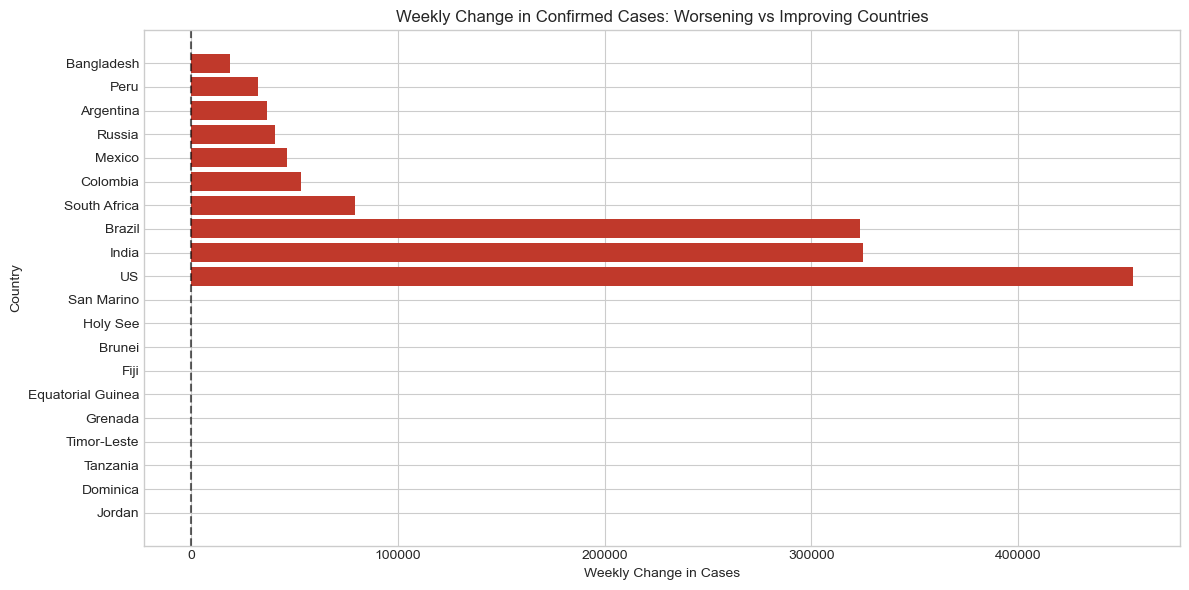

In [16]:
# Pick top 10 worsening and top 10 improving
worsening = df.sort_values("week_change", ascending=False).head(10)[["country", "week_change"]]
improving = df.sort_values("week_change").head(10)[["country", "week_change"]]

div = pd.concat([improving, worsening])

plt.figure(figsize=(12, 6))
plt.barh(div["country"], div["week_change"], color=["#27ae60" if v < 0 else "#c0392b" for v in div["week_change"]])
plt.axvline(0, linestyle="--", color="black", alpha=0.6)
plt.title("Weekly Change in Confirmed Cases: Worsening vs Improving Countries")
plt.xlabel("Weekly Change in Cases")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


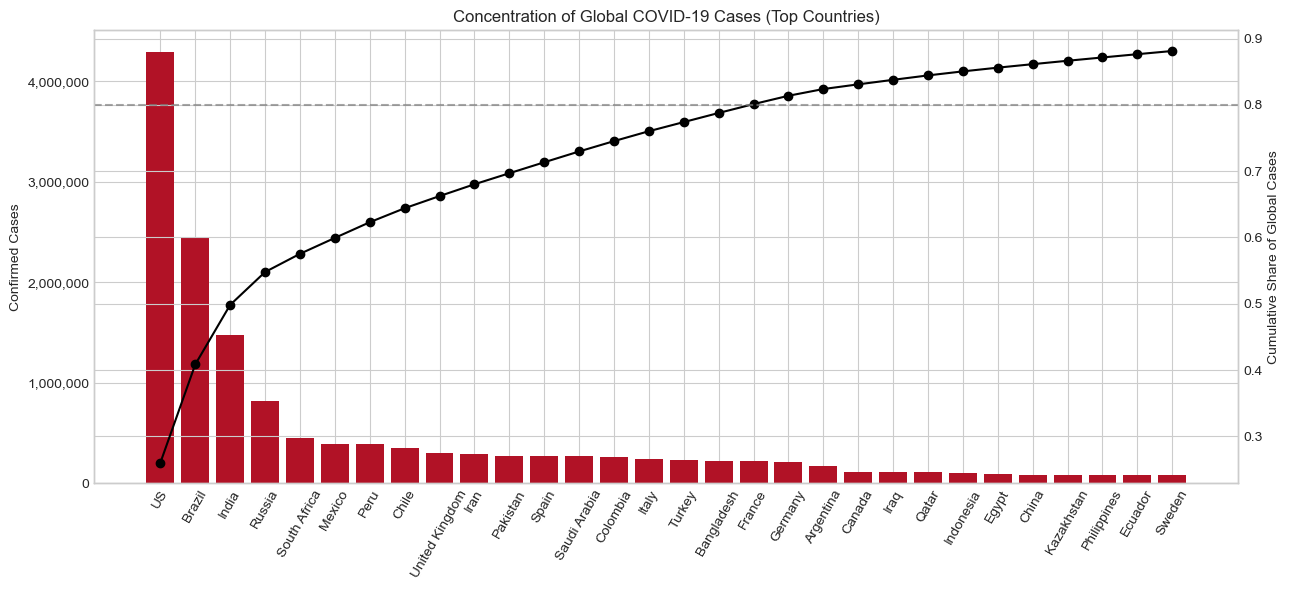

In [18]:
# Sort countries by confirmed cases
pareto = df.sort_values("confirmed", ascending=False).copy()

# Cumulative share of total cases
pareto["cum_share"] = pareto["confirmed"].cumsum() / pareto["confirmed"].sum()

# Keep top 30 for readability
top_n = pareto.head(30)

import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(figsize=(13, 6))
ax1.bar(top_n["country"], top_n["confirmed"], color="#b11226")
ax1.set_ylabel("Confirmed Cases")
ax1.tick_params(axis='x', rotation=60)
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax2 = ax1.twinx()
ax2.plot(top_n["country"], top_n["cum_share"], color="black", marker="o")
ax2.set_ylabel("Cumulative Share of Global Cases")
ax2.axhline(0.8, linestyle="--", color="gray", alpha=0.7)

ax1.set_title("Concentration of Global COVID-19 Cases (Top Countries)")
plt.tight_layout()
plt.show()


This Pareto-style chart shows that a small number of countries account for a disproportionately large share of global COVID-19 cases. The steep rise in cumulative share indicates strong concentration of cases in a few countries rather than uniform distribution worldwide.